<a href="https://colab.research.google.com/github/pankajr141/experiments/blob/master/Reasoning/Reasoning%20%7BAudio%7D%20-%20ASR%20Features%20using%20MFCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Purpose

The purpose of this reasoning notebook, is to look at conventional Features for Audio Speach Recognition. We will apply these signals to voice dataset of different speakers male and female. The Final Aim is to generate a feature vector for each sample that will be easy to fed into any classification algorithm

## References 



*   https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html
*   http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/



## Algorithm

* Frame the signal into short frames.
* For each frame calculate the periodogram estimate of the power spectrum.
* Apply the mel filterbank to the power spectra, sum the energy in each filter.
* Take the logarithm of all filterbank energies.
* Take the DCT of the log filterbank energies.
* Keep DCT coefficients 2-13, discard the rest.

### Mel Scale - Defining our Bin Range using Mel Scale
Human can detect differences in sound at lower freq with much precision then the ones with high. This concept has been used in multiple audio application like mp3 which compresses sounds in such a way that the noise at high freq is much mpre then the low ones, and since we cannot detect high freq with accuracy this go unnoticed. 

---

Mel Scale also use above mentioned characterstics to scale freq into such bins that at lower spectrum we will have narrow range bins and as we go high the range of bins increases. This ensures that we are giving lower spectum much more importance then the high ones. The end features which we will get are more closely related to what we human can percieve or hear.


![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/a/aa/Mel-Hz_plot.svg/900px-Mel-Hz_plot.svg.png)

Looking at above scale we can see that how scale tilt at higher freq, meaning if we take equi space window bins at Mel Scale, then at lower freq we will have narrower band then at high freq.


![alt text](http://www.ee.columbia.edu/~dpwe/LabROSA/doc/HTKBook21/img165.gif)

Now Filter based on above bins can be seen as we have more and narrower filters in lower freq then higher ones.


In [0]:
import numpy as np

"""Convert Freq to Mel Scale"""
def freq_to_mel(freq):
  return 1125 * np.log(1 + freq/700)

"""Convert Mel Scale to Freq"""
def mel_to_freq(mel):
  return 700 * (np.exp(mel/1125) - 1)

Suppose we are only interested in **freq range 300 Hz - 8000 Hz**

In [0]:
lower_freq = 300 #Hz
upper_freq = 8000 # Hz

lower_mel = freq_to_mel(300)
upper_mel = freq_to_mel(8000)

"Mel Freq Range:", lower_mel, upper_mel

('Mel Freq Range:', 401.25931193107397, 2834.997715799179)

**Lets create 40 Bins with Mel Scale in which we want our features to be present**

In [0]:
mel_fzs = np.linspace(lower_mel, upper_mel, 42)
str(mel_fzs)

'[ 401.25931193  460.6187852   519.97825846  579.33773173  638.69720499\n  698.05667826  757.41615152  816.77562479  876.13509805  935.49457132\n  994.85404458 1054.21351785 1113.57299111 1172.93246438 1232.29193764\n 1291.65141091 1351.01088417 1410.37035744 1469.7298307  1529.08930397\n 1588.44877723 1647.8082505  1707.16772376 1766.52719703 1825.88667029\n 1885.24614356 1944.60561682 2003.96509009 2063.32456335 2122.68403662\n 2182.04350988 2241.40298315 2300.76245641 2360.12192968 2419.48140294\n 2478.84087621 2538.20034947 2597.55982274 2656.919296   2716.27876927\n 2775.63824253 2834.9977158 ]'

**Converting Mel freq back to Freq**

In [0]:
fzs = [mel_to_freq(x) for x in mel_fzs]
str(fzs)

'[300.0, 354.1808040326042, 411.2971675908279, 471.5081416500546, 534.9813946953967, 601.8936796253001, 672.4313259523643, 746.7907586719966, 825.1790452437867, 907.8144722087746, 994.9271530483034, 1086.7596689771533, 1183.567744455365, 1285.6209592998352, 1393.2034993786915, 1506.6149479788899, 1626.1711200507493, 1752.2049416525217, 1885.0673770439807, 2025.1284060106793, 2172.778054140426, 2328.427478920975, 2492.5101146833463, 2665.4828795791113, 2847.827447952671, 3040.0515916516897, 3242.6905940108, 3456.308740446091, 3681.5008898111987, 3918.8941308907415, 4169.1495286438785, 4432.96396506078, 4711.072079758154, 5004.248315717828, 5313.3090758650505, 5639.114996491973, 5982.573343857046, 6344.640540634072, 6726.324829246307, 7128.689079502162, 7552.853748350855, 7999.999999999999]'

Since we lack the frequency resolution, we need to rount above frequency to nearest FFT bin

In [0]:
sample_rate = 16000 #16KHz
nfft = 512 # Window size for fft

bin  = np.floor(((nfft + 1) * np.array(fzs)) / sample_rate).astype(int)
print("Total Bins:", len(bin))
bin

Total Bins: 42


array([  9,  11,  13,  15,  17,  19,  21,  23,  26,  29,  31,  34,  37,
        41,  44,  48,  52,  56,  60,  64,  69,  74,  79,  85,  91,  97,
       103, 110, 118, 125, 133, 142, 151, 160, 170, 180, 191, 203, 215,
       228, 242, 256])

### Filter Banks - using Mel Scale


Assuming we are getting below array as our bins 
```
array([  9,  11,  13,  15,  17,  19,  21,  23,  26,  29,  31,  34,  37,
        41,  44,  48,  52,  56,  60,  64,  69,  74,  79,  85,  91,  97,
       103, 110, 118, 125, 133, 142, 151, 160, 170, 180, 191, 203, 215,
       228, 242, 256])
```

The Flter banks are designed such a way that they take 3 points to form a filter. Start, Peak and End. 

```Eg. 9, 11, 13```

Here out triangular filter will start at 6Hz reach its peak at 16 and then ends at 25 Hz




---



![alt text](http://practicalcryptography.com/media/latex/9dbdba8524bc6c95d056048f37b0a4ea4194de45-11pt.png)

*Lets Visualize our filter banks*

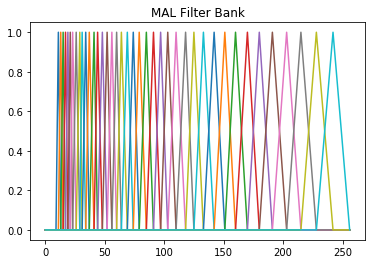

In [0]:
NFFT = 512
num_filt = 40

fbank = np.zeros((num_filt, int(np.floor(NFFT / 2 + 1))))

for m in range(1, num_filt + 1):
  f_m_minus = int(bin[m - 1])   # left
  f_m = int(bin[m])             # center
  f_m_plus = int(bin[m + 1])    # right

  for k in range(f_m_minus, f_m):
    fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
  for k in range(f_m, f_m_plus):
    fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])

import matplotlib.pyplot as plt

for i in range(fbank.shape[0]):
  plt.plot(fbank[i])
plt.title('MAL Filter Bank')
plt.show()

# mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
# pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

# filter_banks = np.dot(pow_frames, fbank.T)
# filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
# filter_banks = 20 * np.log10(filter_banks)


### Dataset - Signal

Till Now we were generating our filter Banks, now lets operate on our signals.

In [0]:
import os

directory = "/content/drive/My Drive/datasets/audio/experiment_text_wave_combination/sentence/1"
samples = [os.path.join(directory, x) for x in os.listdir(directory) if x.endswith('wav')]

samples[0:2], len(samples)

(['/content/drive/My Drive/datasets/audio/experiment_text_wave_combination/sentence/1/voice_en_male_0_sentence_1.wav',
  '/content/drive/My Drive/datasets/audio/experiment_text_wave_combination/sentence/1/voice_en_male_1_sentence_1.wav'],
 32)

Till Now we were generating our filter Banks, now lets operate on our signals.

### Dividing Signal into multiple frames with overlapping
Typical frame sizes in speech processing range from 20 ms to 40 ms with 50% (+/-10%) overlap between consecutive frames. Popular settings are 25 ms for the frame size, frame_size = 0.025 and a 10 ms stride (15 ms overlap), frame_stride = 0.01.

In [0]:
import scipy.io.wavfile
import numpy as np

def get_window_frames(signal, sample_rate, frame_stride=0.01, frame_size=0.025):
  '''Divide the signal into equal sized frames with overlapping'''

  frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
  frame_length, frame_step = int(round(frame_length)), int(round(frame_step))
  
  print("sample rate: %f\tframe_stride: %f\tframe_size: %f\tframe_length: %f\tframe_step: %f\t" % (sample_rate, frame_stride, frame_size, frame_length, frame_step))
  
  signal_length = len(signal)
  num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

  pad_signal_length = num_frames * frame_step + frame_length
  z = np.zeros((pad_signal_length - signal_length))
  pad_signal = np.append(signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

  indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
  frames = pad_signal[indices.astype(np.int32, copy=False)]
  return frames

sample_rate, signal = scipy.io.wavfile.read('/content/drive/My Drive/datasets/audio/experiment_text_wave_combination/sentence/1/voice_en_male_0_sentence_1.wav')
frames = get_window_frames(signal, sample_rate)

print("Total Frames:", frames.shape[0], frames.shape, signal.shape, frames.shape[0] * frames.shape[1])
print("We have %d frames with %d length each" % (frames.shape))

sample rate: 24000.000000	frame_stride: 0.010000	frame_size: 0.025000	frame_length: 600.000000	frame_step: 240.000000	
Total Frames: 317 (317, 600) (76608,) 190200
We have 317 frames with 600 length each


### Applying Hamming window on Frames

Since we cut off the signal, the start and end of singal will not match, it looks like a discontinuity in the signal which will show up as a high frequency nonsense in fourier transform. '
Windowing the data makes sure that the ends match up while keeping everything reasonably smooth; this greatly reduces the sort of "spectral leakage" described above.


https://stackoverflow.com/questions/5418951/what-is-the-hamming-window-for
Look at 2nd Answer Good one.


In [0]:
from scipy import signal

frame_length = frames.shape[1]
# frames = frames * signal.tukey(frame_length, alpha=0.25)
frames = frames * np.hamming(frame_length)
print(frames.shape)

(317, 600)


### Spectogram - Applying FFT on Frames (Hamming window output)

we will be using np.fft.rfft instead of np.fft.fft which is computed for purely real input.

**As in docs -** The negative frequency terms are just the complex conjugates of the corresponding positive-frequency terms, and the negative-frequency terms are therefore redundant. This function does not compute the negative frequency terms, and the length of the transformed axis of the output is therefore n//2 + 1.


Will do a N point FFT on each frame, also known as short time fourier transform. **N is 256 or 512**. 


---

<font color='blue'>*Based on numpy.fft.rfft documentation N is - Number of points along transformation axis in the input to use. If n is smaller than the length of the input, the input is cropped. If it is larger, the input is padded with zeros. If n is not given, the length of the input along the axis specified by axis is used.*</font>

---

**Power Spectrum / Spectral Density / Periodogram** - Density (PSD) is a frequency-domain plot of power per Hz vs frequency.
A periodogram is just the squared magnitude of the Fourier transform of a signal.

---
<font color='green'>Plotting **Periodogram** over time would give something like a **spectrogram**.</font>
 

(317, 257) (317, 257)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log10


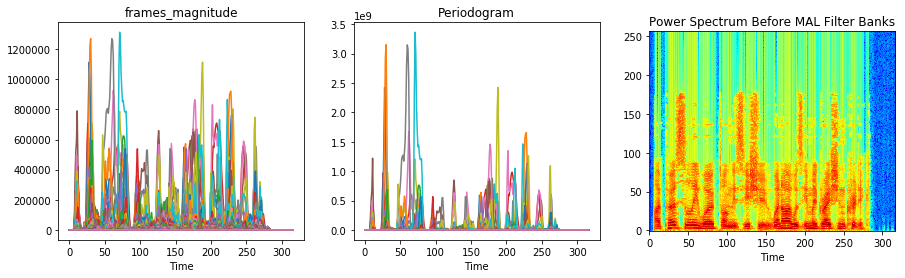

In [0]:
NFFT = 512

'''Short Fast Fourier Transform'''
frames_magnitude = np.abs(np.fft.rfft(frames, NFFT)) 

'''Periodogram '''
frames_power_spectrum = ((1.0 / NFFT) * ((frames_magnitude) ** 2))  # Power Spectrum (periodogram)

print(frames_magnitude.shape, frames_power_spectrum.shape)

'''Lets Plot'''
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15, 4))
ax1 = fig.add_subplot(1,3,1)
ax1.set_title("frames_magnitude")
ax1.set_xlabel('Time')
ax1.plot(frames_magnitude)

ax2 = fig.add_subplot(1,3,2)
ax2.set_title("Periodogram")
ax2.set_xlabel('Time')
ax2.plot(frames_power_spectrum)

ax3 = fig.add_subplot(1,3,3)
ax3.set_title("Power Spectrum Before MAL Filter Banks")
ax3.set_xlabel('Time')
ax3.imshow(20 * np.log10(frames_power_spectrum).T, origin='lower', cmap=plt.cm.jet)
# ax3.imshow(frames_power_spectrum.T, origin='lower')
plt.show()

In [0]:
frames_power_spectrum.shape, fbank.shape

((317, 257), (40, 257))

### Applying Mel Filter Banks on FFT output

Remember our bin is - 

```
array([  9,  11,  13,  15,  17,  19,  21,  23,  26,  29,  31,  34,  37,
        41,  44,  48,  52,  56,  60,  64,  69,  74,  79,  85,  91,  97,
       103, 110, 118, 125, 133, 142, 151, 160, 170, 180, 191, 203, 215,
       228, 242, 256])

```
And our periodogram has frequency response in this range.

Let apply our filter banks here. 


(317, 40)


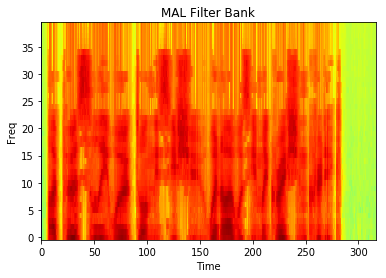

In [0]:
filter_banks = np.dot(frames_power_spectrum, fbank.T)
print(filter_banks.shape)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks) # Numerical Stability ?
filter_banks = 20 * np.log10(filter_banks)  # dB

import matplotlib.pyplot as plt
plt.imshow(filter_banks.T,  origin='lower', cmap=plt.cm.jet, aspect='auto')
plt.xlabel('Time')
plt.ylabel('Freq')

plt.title('MAL Filter Bank')
plt.show()

### Applying MFCCs (Mel-Frequency Cepstral Coefficients) on Filter Banks output

Filter bank coefficient calculated above are highly correlated, since our filterbanks are designed in a way that they overlap each other. We will apply DCT (Discrete Cosine Transform) to decorrelated and get a compressed representation of filter banks.

We will keep only 12 out of 40 DCT coefficients, because higher coefficients fast change in energies of filterbank, which degrades our Features performance when feeded to any ML Alogrithm


For Automatic Speech Recognition (ASR), the resulting cepstral coefficients 2-13 are retained and the rest are discarded; **num_ceps = 12**. 

Lift: [ 1.          2.56546322  4.09905813  5.56956514  6.94704899  8.20346807
  9.31324532 10.25378886 11.00595195 11.55442271 11.88803586 12.        ]
mfcc shape: (317, 12)


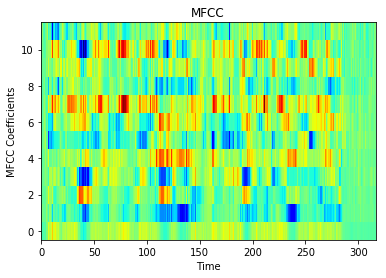

In [0]:
from scipy.fftpack import dct

num_ceps = 12
cep_lifter = 22

mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13

### Apply sinusoidal liftering to the MFCCs to de-emphasize higher MFCCs
(nframes, ncoeff) = mfcc.shape
n = np.arange(ncoeff)

lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
print("Lift:", lift)

mfcc *= lift  #*
print("mfcc shape:", mfcc.shape)

import matplotlib.pyplot as plt
plt.imshow(mfcc.T,  origin='lower', cmap=plt.cm.jet, aspect='auto')
plt.xlabel('Time')
plt.ylabel('MFCC Coefficients')

plt.title('MFCC')
plt.show()

### Mean Normalization on Filter Banks output

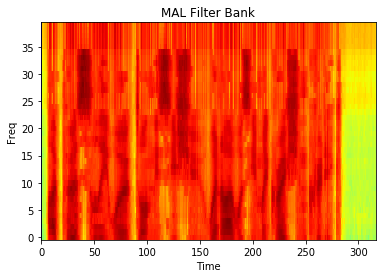

In [0]:
filter_banks_mn = filter_banks - (np.mean(filter_banks, axis=0) + 1e-8)

import matplotlib.pyplot as plt
plt.imshow(filter_banks_mn.T,  origin='lower', cmap=plt.cm.jet, aspect='auto')
plt.xlabel('Time')
plt.ylabel('Freq')

plt.title('MAL Filter Bank')
plt.show()

## Using Other methods to  generate spectogram

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:7609: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


spectogram: (257, 477)
time: (477,)
frequencies: (257,)


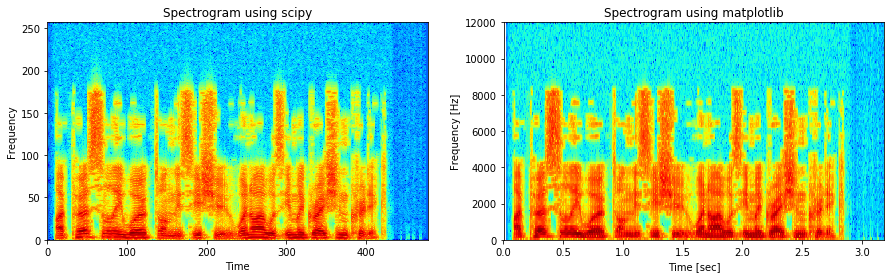

In [0]:

sample_rate, signal_ = scipy.io.wavfile.read('/content/drive/My Drive/datasets/audio/experiment_text_wave_combination/sentence/1/voice_en_male_0_sentence_1.wav')

from scipy import signal
# frequencies, times, spectogram  = signal.spectrogram(signal_, fs=sample_rate, window=('tukey', 0.25), nperseg=400, noverlap=240, nfft=512, detrend='constant', return_onesided=False, scaling='density', axis=-1, mode='psd')
frequencies, times, spectogram  = signal.spectrogram(signal_, fs=sample_rate, nperseg=400, noverlap=240, nfft=512, window=('tukey', 0.25))

fig = plt.figure(figsize = (15, 4))
ax1 = fig.add_subplot(1,2,1)
ax1.set_title("Spectrogram using scipy")
ax1.set_xlabel('Time')
ax1.set_ylabel('Frequency')
ax1.pcolormesh(10 * np.log10(spectogram), cmap=plt.cm.jet)

print("spectogram:", spectogram.shape)
print("time:", times.shape)
print("frequencies:", frequencies.shape)


import matplotlib.pyplot as plt
ax2 = fig.add_subplot(1,2,2)
powerSpectrum, freqenciesFound, time, imageAxis =  ax2.specgram(signal_, Fs=sample_rate, cmap=plt.cm.jet)
ax2.set_title("Spectrogram using matplotlib")
ax2.set_xlabel('Time [sec]')
ax2.set_ylabel('Frequency [Hz]')
plt.show()

## Pipeline on Samples

Below we will merge all the code and create a pipeline

---


<img src='https://pankajr141.files.wordpress.com/2019/09/io.png?w=391'/>


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10


spectogram: (257, 477)
time: (477,)
frequencies: (257,)
(477, 40)
mfcc shape: (477, 12)


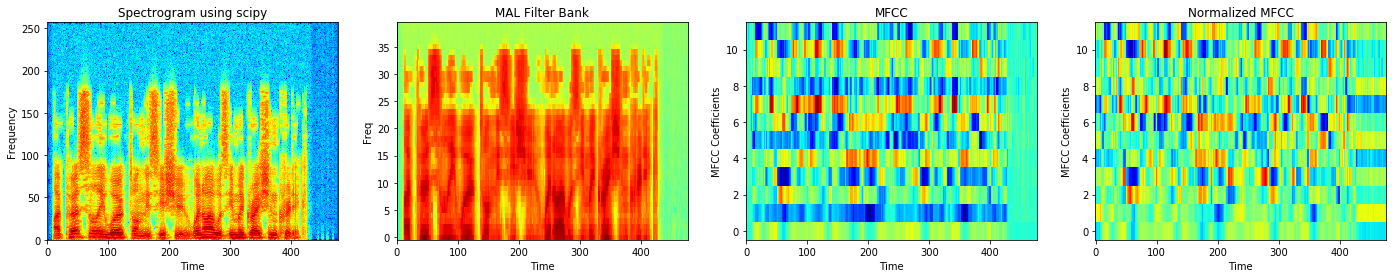

spectogram: (257, 466)
time: (466,)
frequencies: (257,)
(466, 40)
mfcc shape: (466, 12)


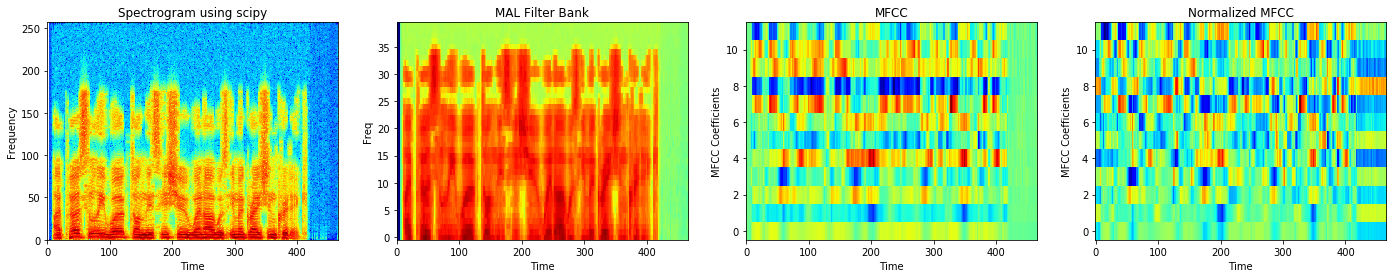

spectogram: (257, 513)
time: (513,)
frequencies: (257,)
(513, 40)
mfcc shape: (513, 12)


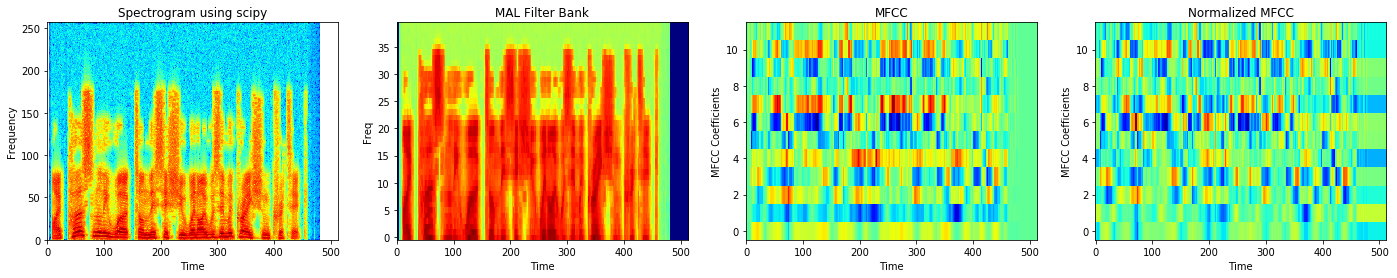

In [0]:
import scipy.io.wavfile
import scipy.signal
from scipy.fftpack import dct
import matplotlib.pyplot as plt

  
def pipeline(audiofile, fbank):
  ''' Reading file '''
  sample_rate, signal_ = scipy.io.wavfile.read(audiofile)
  
  ''' Calculating Spectogram '''  
  frequencies, times, spectogram  = scipy.signal.spectrogram(signal_, fs=sample_rate, nperseg=400, noverlap=240, nfft=512, window=('tukey', 0.25))
    
  fig = plt.figure(figsize = (24, 4))
  ax1 = fig.add_subplot(1,4,1)
  ax1.set_title("Spectrogram using scipy")
  ax1.set_xlabel('Time')
  ax1.set_ylabel('Frequency')
  ax1.pcolormesh(10 * np.log10(spectogram), cmap=plt.cm.jet)

  print("spectogram:", spectogram.shape)
  print("time:", times.shape)
  print("frequencies:", frequencies.shape)

  
  ''' Calculating MAL Filterbanks '''  

  filter_banks = np.dot(spectogram.T, fbank.T)
  print(filter_banks.shape)
 
  filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks) # Numerical Stability ?
  filter_banks = 20 * np.log10(filter_banks)  # dB

  ax2 = fig.add_subplot(1,4,2)

  ax2.imshow(filter_banks.T,  origin='lower', cmap=plt.cm.jet, aspect='auto')
  ax2.set_xlabel('Time')
  ax2.set_ylabel('Freq')
  ax2.set_title('MAL Filter Bank')

  ''' MFCC (Mel-Frequency Cepstral Coefficients)'''
  num_ceps = 12
  cep_lifter = 22

  mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13

  ### Apply sinusoidal liftering to the MFCCs to de-emphasize higher MFCCs
  (nframes, ncoeff) = mfcc.shape
  n = np.arange(ncoeff)

  lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
  
  mfcc *= lift  #*
  print("mfcc shape:", mfcc.shape)

  ax3 = fig.add_subplot(1,4,3)
  ax3.imshow(mfcc.T,  origin='lower', cmap=plt.cm.jet, aspect='auto')
  ax3.set_xlabel('Time')
  ax3.set_ylabel('MFCC Coefficients')
  ax3.set_title('MFCC')

  
  ### Normalized MFCC
  mfcc = mfcc - (np.mean(mfcc, axis=0) + 1e-8)
  
  ax4 = fig.add_subplot(1,4,4)
  ax4.imshow(mfcc.T,  origin='lower', cmap=plt.cm.jet, aspect='auto')
  ax4.set_xlabel('Time')
  ax4.set_ylabel('MFCC Coefficients')
  ax4.set_title('Normalized MFCC')
  plt.show()
  
for i in range(3):
  pipeline(samples[i], fbank)

**Above we can see that different speakers have different speaking patterns for the same data, this can be used for speech classification.**